In [68]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import integrate
# import math
# from functools import lru_cache

# # ============================================================
# # 0) Background cosmology helpers (units: Mpc/h, Msun/h)
# # ============================================================

# def rho_m0_comoving(Omega_m: float) -> float:
#     """
#     Present-day mean matter density ρ_m0 in comoving units (Msun/h)/(Mpc/h)^3.

#     Uses: ρ_crit0 = 2.775e11 h^2 Msun/Mpc^3
#     => in (Msun/h)/(Mpc/h)^3, the h factors cancel, giving 2.775e11.
#     """
#     return 2.775e11 * Omega_m  # (Msun/h)/(Mpc/h)^3


# def mass_to_tophat_radius(M_msun_over_h: float, Omega_m: float) -> float:
#     """
#     Convert mass M (Msun/h) to comoving tophat radius R (Mpc/h):
#       M = (4π/3) ρ_m0 R^3
#     """
#     rho0 = rho_m0_comoving(Omega_m)
#     return (3.0 * M_msun_over_h / (4.0 * np.pi * rho0)) ** (1.0 / 3.0)


# # ============================================================
# # 1) Linear growth and spherical-collapse threshold δ_sc(z)
# # ============================================================

# def E_of_a(a: float, Omega_m: float, Omega_L: float) -> float:
#     """E(a)=H(a)/H0 for flat ΛCDM (radiation neglected)."""
#     return np.sqrt(Omega_m / a**3 + Omega_L)


# def growth_factor_Dz(z: float, Omega_m: float, Omega_L: float) -> float:
#     """
#     Linear growth factor D(z), normalized to D(0)=1.

#     Uses integral solution (standard):
#       D(a) ∝ E(a) ∫ da' / [a'^3 E(a')^3], normalized to a=1.
#     """
#     a = 1.0 / (1.0 + z)

#     def integrand(a_prime):
#         return 1.0 / (a_prime**3 * E_of_a(a_prime, Omega_m, Omega_L) ** 3)

#     a_min = 1e-6
#     I_a, _ = integrate.quad(integrand, a_min, a, limit=300)
#     I_1, _ = integrate.quad(integrand, a_min, 1.0, limit=300)

#     pref_a = 2.5 * Omega_m * E_of_a(a, Omega_m, Omega_L)
#     pref_1 = 2.5 * Omega_m * E_of_a(1.0, Omega_m, Omega_L)

#     D_a = pref_a * I_a
#     D_1 = pref_1 * I_1
#     return D_a / D_1


# def delta_sc_z(z: float, Omega_m: float, Omega_L: float, delta_c0: float = 1.686) -> float:
#     """
#     Spherical-collapse threshold in linear theory:
#       δ_sc(z) = δ_c0 / D(z)

#     Used throughout Shen+06 when defining ν and barriers (around Eq. 2–3).
#     """
#     return delta_c0 / growth_factor_Dz(z, Omega_m, Omega_L)


# # ============================================================
# # 2) Power spectrum + σ(R) normalization to σ8
# # ============================================================

# def T_EH98_nowiggle(k_hmpc: float, Omega_m: float, Omega_b: float, h: float, Tcmb: float = 2.7255) -> float:
#     """
#     Simple analytic no-wiggle transfer (BBKS-like with baryon correction).
#     This is an approximation; for best match to the paper, swap to CAMB/CLASS.

#     Input k in h/Mpc. Output dimensionless T(k).
#     """
#     theta = Tcmb / 2.7
#     Omh2 = Omega_m * h**2
#     Obh2 = Omega_b * h**2

#     gamma_eff = Omh2 * np.exp(-Omega_b * (1.0 + np.sqrt(2.0 * h) / Omega_m))
#     q = k_hmpc / gamma_eff

#     L0 = np.log(1.0 + 2.34 * q)
#     C0 = (1.0 + 3.89*q + (16.1*q)**2 + (5.46*q)**3 + (6.71*q)**4) ** 0.25
#     return (L0 / (2.34*q + 1e-30)) / C0


# def W_tophat(kR: float) -> float:
#     """Fourier-space spherical tophat window W(kR)."""
#     return 3.0 * (np.sin(kR) - kR * np.cos(kR)) / (kR**3 + 1e-30)


# def Pk_shape(k_hmpc: float, Omega_m: float, Omega_b: float, h: float, n_s: float) -> float:
#     """
#     Unnormalized linear P(k) shape:
#       P(k) ∝ k^{n_s} T(k)^2
#     """
#     T = T_EH98_nowiggle(k_hmpc, Omega_m, Omega_b, h)
#     return (k_hmpc ** n_s) * (T ** 2)


# def _sigma2_R_for_A(R_mpc_over_h: float, A: float,
#                     Omega_m: float, Omega_b: float, h: float, n_s: float,
#                     kmin=1e-4, kmax=1e2) -> float:
#     """
#     σ^2(R) = ∫ dlnk [ k^3 P(k) / (2π^2) ] W(kR)^2
#     with P(k) = A * Pk_shape(k).
#     """
#     def integrand(lnk):
#         k = np.exp(lnk)
#         P = A * Pk_shape(k, Omega_m, Omega_b, h, n_s)
#         return (k**3 * P / (2.0 * np.pi**2)) * (W_tophat(k * R_mpc_over_h) ** 2)

#     val, _ = integrate.quad(integrand, np.log(kmin), np.log(kmax), limit=500)
#     return val


# def power_spectrum_amplitude_from_sigma8(sigma8: float,
#                                          Omega_m: float, Omega_b: float, h: float, n_s: float) -> float:
#     """
#     Compute amplitude A such that σ(8 Mpc/h) = sigma8.
#     This is done ONCE, then reused.
#     """
#     sigma2_R8_A1 = _sigma2_R_for_A(8.0, A=1.0, Omega_m=Omega_m, Omega_b=Omega_b, h=h, n_s=n_s)
#     return (sigma8**2) / sigma2_R8_A1


# def sigma_R(R_mpc_over_h: float, A: float,
#             Omega_m: float, Omega_b: float, h: float, n_s: float) -> float:
#     """σ(R) using precomputed amplitude A."""
#     return np.sqrt(_sigma2_R_for_A(R_mpc_over_h, A=A, Omega_m=Omega_m, Omega_b=Omega_b, h=h, n_s=n_s))


# # ============================================================
# # 3) Shen+06 excursion-set quantities for SHEETS
# # ============================================================

# def nu_peakheight(M_msun_over_h: float, z: float,
#                   A: float, Omega_m: float, Omega_L: float, Omega_b: float, h: float, n_s: float) -> float:
#     """
#     Shen+06 ν definition (around Eq. 2–3):
#       ν ≡ [ δ_sc(z) / σ(M) ]^2
#     """
#     R = mass_to_tophat_radius(M_msun_over_h, Omega_m)
#     sig = sigma_R(R, A, Omega_m, Omega_b, h, n_s)
#     dsc = delta_sc_z(z, Omega_m, Omega_L)
#     return (dsc / sig) ** 2


# def delta_ec1_sheet(sig: float, z: float, Omega_m: float, Omega_L: float) -> float:
#     """
#     Shen+06 Eq. (2) — SHEET barrier δ_ec1(σ,z):

#       δ_ec1(σ,z) = δ_sc(z) * [ 1 - 0.56 * (σ^2 / δ_sc(z)^2)^{0.55} ]
#     """
#     dsc = delta_sc_z(z, Omega_m, Omega_L)
#     return dsc * (1.0 - 0.56 * ((sig**2) / (dsc**2)) ** 0.55)


# def delta_ec_moving_barrier(nu: float, z: float, Omega_m: float, Omega_L: float,
#                             alpha: float, beta: float) -> float:
#     """
#     Shen+06 Eq. (3) moving barrier form:

#       δ_ec = δ_sc(z) * [1 + β ν^{-α}]

#     For SHEETS: alpha=0.55, beta=-0.56 (equivalent to Eq. 2).
#     """
#     dsc = delta_sc_z(z, Omega_m, Omega_L)
#     return dsc * (1.0 + beta * nu ** (-alpha))


# def series_bracket(alpha: float, n_terms: int = 5) -> float:
#     """
#     The bracketed series appearing in Shen+06 Eq. (4):
#       S(α) = 1 - α + α(α-1)/2! + α(α-1)(α-2)/3! + ...

#     Returns S(α) truncated at n_terms (where n_terms>=1 includes the -α term).
#     """
#     S = 1.0  # n=0 term
#     if n_terms >= 1:
#         S += -alpha  # n=1 term
#     for n in range(2, n_terms + 1):
#         prod = 1.0
#         for j in range(n):
#             prod *= (alpha - j)
#         S += prod / math.factorial(n)  # <-- FIX: use math.factorial
#     return S

# def nu_f_nu_moving_barrier(nu, alpha, beta, n_series_terms=5, use_series=True):
#     """
#     Shen+06 Eq. (4) approximate first-crossing distribution for Eq. (3) barriers:

#       ν f(ν) = sqrt(ν/2π) * exp[ -ν (1 + β ν^{-α})^2 / 2 ]
#               * { 1 + (β/ν^α) S(α) }

#     where S(α) is the series bracket above.

#     For SHEETS use alpha=0.55, beta=-0.56.
#     """
#     core = np.sqrt(nu / (2.0 * np.pi)) * np.exp(-0.5 * nu * (1.0 + beta * nu**(-alpha))**2)
#     if not use_series:
#         return core
#     S = series_bracket(alpha, n_terms=n_series_terms)
#     corr = 1.0 + (beta * nu**(-alpha)) * S
#     return core * corr


# @lru_cache(maxsize=4096)
# def _sigmaM_cached(M_msun_over_h: float, A: float,
#                    Omega_m: float, Omega_b: float, h: float, n_s: float) -> float:
#     """Cached σ(M) to speed up repeated calls."""
#     R = mass_to_tophat_radius(M_msun_over_h, Omega_m)
#     return sigma_R(R, A, Omega_m, Omega_b, h, n_s)


# def dlnsigma2_dlnM(M_msun_over_h: float, A: float,
#                    Omega_m: float, Omega_b: float, h: float, n_s: float,
#                    eps: float = 1e-3) -> float:
#     """
#     Needed for Shen+06 Eq. (1). Compute d ln σ^2 / d ln M numerically.
#     """
#     lnM = np.log(M_msun_over_h)
#     M1 = np.exp(lnM * (1.0 - eps))
#     M2 = np.exp(lnM * (1.0 + eps))

#     sig1 = _sigmaM_cached(M1, A, Omega_m, Omega_b, h, n_s)
#     sig2 = _sigmaM_cached(M2, A, Omega_m, Omega_b, h, n_s)

#     return (np.log(sig2**2) - np.log(sig1**2)) / (np.log(M2) - np.log(M1))


# def n_sheet_M_z(M_msun_over_h: float, z: float,
#                 A: float, Omega_m: float, Omega_L: float, Omega_b: float, h: float, n_s: float,
#                 alpha_sheet: float = 0.55, beta_sheet: float = -0.56,
#                 n_series_terms: int = 5) -> float:
#     """
#     Shen+06 Eq. (1) + Eq. (4) => comoving sheet number density at fixed M,z.

#     Eq. (1) in the paper:
#       ν f(ν) ≡ (M^2 n(M,z) / ρ_m0) * (d ln M / d ln σ^2)

#     Rearranged:
#       n(M,z) = (ρ_m0 / M^2) * [ν f(ν)] * (d ln σ^2 / d ln M)

#     Here we compute ν from δ_sc(z)/σ(M) and use Eq. (4) for ν f(ν).
#     """
#     rho0 = rho_m0_comoving(Omega_m)

#     # ν = [δ_sc(z)/σ(M)]^2
#     sig = _sigmaM_cached(M_msun_over_h, A, Omega_m, Omega_b, h, n_s)
#     dsc = delta_sc_z(z, Omega_m, Omega_L)
#     nu = (dsc / sig) ** 2

#     # ν f(ν) (Eq. 4) with sheet params
#     nu_f = nu_f_nu_moving_barrier(nu, alpha_sheet, beta_sheet, n_series_terms, use_series=True)

#     # d ln σ^2 / d ln M
#     deriv = dlnsigma2_dlnM(M_msun_over_h, A, Omega_m, Omega_b, h, n_s)

#     n = (rho0 / (M_msun_over_h**2)) * nu_f / np.abs(deriv)  # (Mpc/h)^-3
#     return n


# # ============================================================
# # 4) Plot: log10 n_sheet(M,z) vs z for several masses
# # ============================================================

# def plot_sheet_number_density_vs_z(
#     masses_msun_over_h,
#     zmin=0.0,
#     zmax=20.0,
#     nz=80,
#     Omega_m=0.3,
#     Omega_L=0.7,
#     Omega_b=0.048,
#     h=0.7,
#     n_s=0.965,
#     sigma8=0.9,
#     n_series_terms=5,
# ):
#     """
#     Produce a Shen+06 Fig. 3 (bottom-right style) plot for SHEETS:
#       y = log10 n_sheet(M,z)  in (Mpc/h)^-3
#       x = z
#     """
#     # Compute P(k) amplitude once
#     A = power_spectrum_amplitude_from_sigma8(sigma8, Omega_m, Omega_b, h, n_s)

#     zs = np.linspace(zmin, zmax, nz)
#     plt.figure(figsize=(7.5, 5.4))

#     for M in masses_msun_over_h:
#         ns = []
#         for z in zs:
#             dn_dM = n_sheet_M_z(
#                 M, z, A,
#                 Omega_m, Omega_L, Omega_b, h, n_s,
#                 n_series_terms=n_series_terms
#             )
#             dn_dlnM = M * dn_dM
#             ns.append(np.nan if dn_dlnM <= 0 else dn_dlnM)

#         plt.plot(zs, np.log10(np.array(ns)), label=f"M={M:.0e} Msun/h")

#     plt.xlabel("Redshift z")
#     plt.ylabel(r"$\log_{10}\, n_{\rm sheet}(M,z)\ \left[(\mathrm{Mpc}/h)^{-3}\right]$")
#     plt.title("Shen+06-style abundance evolution (Sheets only)")
#     plt.legend(frameon=False)
#     plt.grid(True, alpha=0.25)
#     plt.ylim(-9, 0.5)
#     plt.xlim(0, 20)

#     plt.show()


# # ============================================================
# # Run example
# # ============================================================
# masses = np.asarray([1e10, 1e11, 1e12, 1e13, 1e14, 1e15]) # Msun/h
# plot_sheet_number_density_vs_z(masses, n_series_terms=5)


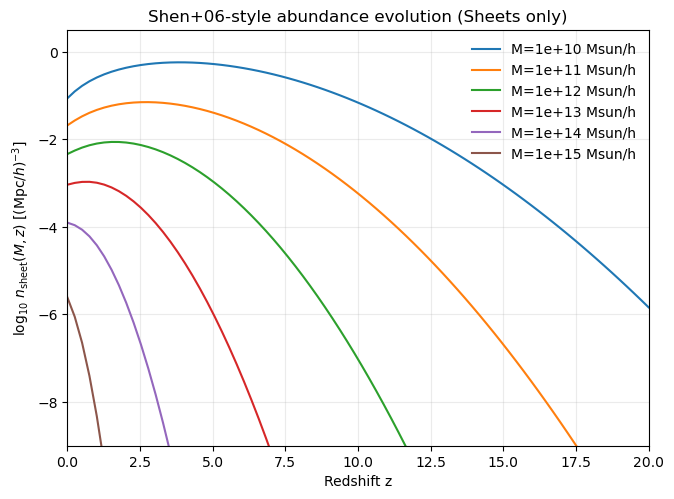

In [71]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import integrate
# import math
# from functools import lru_cache

# # ============================================================
# # 0) Background cosmology helpers (units: Mpc/h, Msun/h)
# # ============================================================

# def rho_m0_comoving(Omega_m: float) -> float:
#     """
#     Present-day mean matter density ρ_m0 in comoving units (Msun/h)/(Mpc/h)^3.

#     Uses: ρ_crit0 = 2.775e11 h^2 Msun/Mpc^3
#     => in (Msun/h)/(Mpc/h)^3, the h factors cancel, giving 2.775e11.
#     """
#     return 2.775e11 * Omega_m  # (Msun/h)/(Mpc/h)^3


# def mass_to_tophat_radius(M_msun_over_h: float, Omega_m: float) -> float:
#     """
#     Convert mass M (Msun/h) to comoving tophat radius R (Mpc/h):
#       M = (4π/3) ρ_m0 R^3
#     """
#     rho0 = rho_m0_comoving(Omega_m)
#     return (3.0 * M_msun_over_h / (4.0 * np.pi * rho0)) ** (1.0 / 3.0)


# # ============================================================
# # 1) Linear growth and spherical-collapse threshold δ_sc(z)
# # ============================================================

# def E_of_a(a: float, Omega_m: float, Omega_L: float) -> float:
#     """E(a)=H(a)/H0 for flat ΛCDM (radiation neglected)."""
#     return np.sqrt(Omega_m / a**3 + Omega_L)


# def growth_factor_Dz(z: float, Omega_m: float, Omega_L: float) -> float:
#     """
#     Linear growth factor D(z), normalized to D(0)=1.

#     Uses integral solution (standard):
#       D(a) ∝ E(a) ∫ da' / [a'^3 E(a')^3], normalized to a=1.
#     """
#     a = 1.0 / (1.0 + z)

#     def integrand(a_prime):
#         return 1.0 / (a_prime**3 * E_of_a(a_prime, Omega_m, Omega_L) ** 3)

#     a_min = 1e-6
#     I_a, _ = integrate.quad(integrand, a_min, a, limit=300)
#     I_1, _ = integrate.quad(integrand, a_min, 1.0, limit=300)

#     pref_a = 2.5 * Omega_m * E_of_a(a, Omega_m, Omega_L)
#     pref_1 = 2.5 * Omega_m * E_of_a(1.0, Omega_m, Omega_L)

#     D_a = pref_a * I_a
#     D_1 = pref_1 * I_1
#     return D_a / D_1


# def delta_sc_z(z: float, Omega_m: float, Omega_L: float, delta_c0: float = 1.686) -> float:
#     """
#     Spherical-collapse threshold in linear theory:
#       δ_sc(z) = δ_c0 / D(z)

#     Used throughout Shen+06 when defining ν and barriers (around Eq. 2–3).
#     """
#     return delta_c0 / growth_factor_Dz(z, Omega_m, Omega_L)


# # ============================================================
# # 2) Power spectrum + σ(R) normalization to σ8
# # ============================================================



# def T_BBKS(k_hmpc, Omega_m, h):
#     Gamma = Omega_m * h  # = 0.3 * 0.7 = 0.21
#     q = k_hmpc / Gamma
#     return (1.0 + (6.4*q + (3.0*q)**1.5 + (1.7*q)**2)**1.13)**(-1.0/1.13)


# # def T_EH98_nowiggle(k_hmpc: float, Omega_m: float, Omega_b: float, h: float, Tcmb: float = 2.7255) -> float:
# #     """
# #     Simple analytic no-wiggle transfer (BBKS-like with baryon correction).
# #     This is an approximation; for best match to the paper, swap to CAMB/CLASS.

# #     Input k in h/Mpc. Output dimensionless T(k).
# #     """
# #     theta = Tcmb / 2.7
# #     Omh2 = Omega_m * h**2
# #     Obh2 = Omega_b * h**2

# #     gamma_eff = Omh2 * np.exp(-Omega_b * (1.0 + np.sqrt(2.0 * h) / Omega_m))
# #     q = k_hmpc / gamma_eff

# #     L0 = np.log(1.0 + 2.34 * q)
# #     C0 = (1.0 + 3.89*q + (16.1*q)**2 + (5.46*q)**3 + (6.71*q)**4) ** 0.25
# #     return (L0 / (2.34*q + 1e-30)) / C0


# def W_tophat(kR: float) -> float:
#     """Fourier-space spherical tophat window W(kR)."""
#     return 3.0 * (np.sin(kR) - kR * np.cos(kR)) / (kR**3 + 1e-30)


# def Pk_shape(k_hmpc: float, Omega_m: float, Omega_b: float, h: float, n_s: float) -> float:
#     """
#     Unnormalized linear P(k) shape:
#       P(k) ∝ k^{n_s} T(k)^2
#     """
#     T = T_BBKS(k_hmpc, Omega_m, h)
#     return (k_hmpc ** n_s) * (T ** 2)


# def _sigma2_R_for_A(R_mpc_over_h: float, A: float,
#                     Omega_m: float, Omega_b: float, h: float, n_s: float,
#                     kmin=1e-4, kmax=1e2) -> float:
#     """
#     σ^2(R) = ∫ dlnk [ k^3 P(k) / (2π^2) ] W(kR)^2
#     with P(k) = A * Pk_shape(k).
#     """
#     def integrand(lnk):
#         k = np.exp(lnk)
#         P = A * Pk_shape(k, Omega_m, Omega_b, h, n_s)
#         return (k**3 * P / (2.0 * np.pi**2)) * (W_tophat(k * R_mpc_over_h) ** 2)

#     val, _ = integrate.quad(integrand, np.log(kmin), np.log(kmax), limit=500)
#     return val


# def power_spectrum_amplitude_from_sigma8(sigma8: float,
#                                          Omega_m: float, Omega_b: float, h: float, n_s: float) -> float:
#     """
#     Compute amplitude A such that σ(8 Mpc/h) = sigma8.
#     This is done ONCE, then reused.
#     """
#     sigma2_R8_A1 = _sigma2_R_for_A(8.0, A=1.0, Omega_m=Omega_m, Omega_b=Omega_b, h=h, n_s=n_s)
#     return (sigma8**2) / sigma2_R8_A1


# def sigma_R(R_mpc_over_h: float, A: float,
#             Omega_m: float, Omega_b: float, h: float, n_s: float) -> float:
#     """σ(R) using precomputed amplitude A."""
#     return np.sqrt(_sigma2_R_for_A(R_mpc_over_h, A=A, Omega_m=Omega_m, Omega_b=Omega_b, h=h, n_s=n_s))


# # ============================================================
# # 3) Shen+06 excursion-set quantities for SHEETS
# # ============================================================

# def nu_peakheight(M_msun_over_h: float, z: float,
#                   A: float, Omega_m: float, Omega_L: float, Omega_b: float, h: float, n_s: float) -> float:
#     """
#     Shen+06 ν definition (around Eq. 2–3):
#       ν ≡ [ δ_sc(z) / σ(M) ]^2
#     """
#     R = mass_to_tophat_radius(M_msun_over_h, Omega_m)
#     sig = sigma_R(R, A, Omega_m, Omega_b, h, n_s)
#     dsc = delta_sc_z(z, Omega_m, Omega_L)
#     return (dsc / sig) ** 2


# def delta_ec1_sheet(sig: float, z: float, Omega_m: float, Omega_L: float) -> float:
#     """
#     Shen+06 Eq. (2) — SHEET barrier δ_ec1(σ,z):

#       δ_ec1(σ,z) = δ_sc(z) * [ 1 - 0.56 * (σ^2 / δ_sc(z)^2)^{0.55} ]
#     """
#     dsc = delta_sc_z(z, Omega_m, Omega_L)
#     return dsc * (1.0 - 0.56 * ((sig**2) / (dsc**2)) ** 0.55)


# def delta_ec_moving_barrier(nu: float, z: float, Omega_m: float, Omega_L: float,
#                             alpha: float, beta: float) -> float:
#     """
#     Shen+06 Eq. (3) moving barrier form:

#       δ_ec = δ_sc(z) * [1 + β ν^{-α}]

#     For SHEETS: alpha=0.55, beta=-0.56 (equivalent to Eq. 2).
#     """
#     dsc = delta_sc_z(z, Omega_m, Omega_L)
#     return dsc * (1.0 + beta * nu ** (-alpha))


# def series_bracket(alpha: float, n_terms: int = 5) -> float:
#     """
#     The bracketed series appearing in Shen+06 Eq. (4):
#       S(α) = 1 - α + α(α-1)/2! + α(α-1)(α-2)/3! + ...

#     Returns S(α) truncated at n_terms (where n_terms>=1 includes the -α term).
#     """
#     S = 1.0  # n=0 term
#     if n_terms >= 1:
#         S += -alpha  # n=1 term
#     for n in range(2, n_terms + 1):
#         prod = 1.0
#         for j in range(n):
#             prod *= (alpha - j)
#         S += prod / math.factorial(n)  # <-- FIX: use math.factorial
#     return S

# def nu_f_nu_moving_barrier(nu, alpha, beta, n_series_terms=5, use_series=True):
#     """
#     Shen+06 Eq. (4) approximate first-crossing distribution for Eq. (3) barriers:

#       ν f(ν) = sqrt(ν/2π) * exp[ -ν (1 + β ν^{-α})^2 / 2 ]
#               * { 1 + (β/ν^α) S(α) }

#     where S(α) is the series bracket above.

#     For SHEETS use alpha=0.55, beta=-0.56.
#     """
#     core = np.sqrt(nu / (2.0 * np.pi)) * np.exp(-0.5 * nu * (1.0 + beta * nu**(-alpha))**2)
#     if not use_series:
#         return core
#     S = series_bracket(alpha, n_terms=n_series_terms)
#     corr = 1.0 + (beta * nu**(-alpha)) * S
#     return core * corr


# @lru_cache(maxsize=4096)
# def _sigmaM_cached(M_msun_over_h: float, A: float,
#                    Omega_m: float, Omega_b: float, h: float, n_s: float) -> float:
#     """Cached σ(M) to speed up repeated calls."""
#     R = mass_to_tophat_radius(M_msun_over_h, Omega_m)
#     return sigma_R(R, A, Omega_m, Omega_b, h, n_s)


# def dlnsigma2_dlnM(M_msun_over_h: float, A: float,
#                    Omega_m: float, Omega_b: float, h: float, n_s: float,
#                    eps: float = 1e-3) -> float:
#     """
#     Needed for Shen+06 Eq. (1). Compute d ln σ^2 / d ln M numerically.
#     """
#     lnM = np.log(M_msun_over_h)
#     M1 = np.exp(lnM * (1.0 - eps))
#     M2 = np.exp(lnM * (1.0 + eps))

#     sig1 = _sigmaM_cached(M1, A, Omega_m, Omega_b, h, n_s)
#     sig2 = _sigmaM_cached(M2, A, Omega_m, Omega_b, h, n_s)

#     return (np.log(sig2**2) - np.log(sig1**2)) / (np.log(M2) - np.log(M1))


# def n_sheet_M_z(M_msun_over_h: float, z: float,
#                 A: float, Omega_m: float, Omega_L: float, Omega_b: float, h: float, n_s: float,
#                 alpha_sheet: float = 0.55, beta_sheet: float = -0.56,
#                 n_series_terms: int = 5) -> float:
#     """
#     Shen+06 Eq. (1) + Eq. (4) => comoving sheet number density at fixed M,z.

#     Eq. (1) in the paper:
#       ν f(ν) ≡ (M^2 n(M,z) / ρ_m0) * (d ln M / d ln σ^2)

#     Rearranged:
#       n(M,z) = (ρ_m0 / M^2) * [ν f(ν)] * (d ln σ^2 / d ln M)

#     Here we compute ν from δ_sc(z)/σ(M) and use Eq. (4) for ν f(ν).
#     """
#     rho0 = rho_m0_comoving(Omega_m)

#     # ν = [δ_sc(z)/σ(M)]^2
#     sig = _sigmaM_cached(M_msun_over_h, A, Omega_m, Omega_b, h, n_s)
#     dsc = delta_sc_z(z, Omega_m, Omega_L)
#     nu = (dsc / sig) ** 2

#     # ν f(ν) (Eq. 4) with sheet params
#     nu_f = nu_f_nu_moving_barrier(nu, alpha_sheet, beta_sheet, n_series_terms, use_series=True)

#     # d ln σ^2 / d ln M
#     deriv = dlnsigma2_dlnM(M_msun_over_h, A, Omega_m, Omega_b, h, n_s)

#     n = (rho0 / (M_msun_over_h**2)) * nu_f * np.abs(deriv)  # (Mpc/h)^-3
#     return n


# # ============================================================
# # 4) Plot: log10 n_sheet(M,z) vs z for several masses
# # ============================================================

# def plot_sheet_number_density_vs_z(
#     masses_msun_over_h,
#     zmin=0.0,
#     zmax=20.0,
#     nz=80,
#     Omega_m=0.3,
#     Omega_L=0.7,
#     Omega_b=0.048,
#     h=0.7,
#     n_s=1,
#     sigma8=0.9,
#     n_series_terms=5,
# ):
#     """
#     Produce a Shen+06 Fig. 3 (bottom-right style) plot for SHEETS:
#       y = log10 n_sheet(M,z)  in (Mpc/h)^-3
#       x = z
#     """
#     # Compute P(k) amplitude once
#     A = power_spectrum_amplitude_from_sigma8(sigma8, Omega_m, Omega_b, h, n_s)

#     zs = np.linspace(zmin, zmax, nz)
#     plt.figure(figsize=(7.5, 5.4))

#     for M in masses_msun_over_h:
#         ns = []
#         for z in zs:
#             dn_dM = n_sheet_M_z(
#                 M, z, A,
#                 Omega_m, Omega_L, Omega_b, h, n_s,
#                 n_series_terms=n_series_terms
#             )
#             dn_dlnM = M * dn_dM
#             ns.append(np.nan if dn_dlnM <= 0 else dn_dlnM)

#         plt.plot(zs, np.log10(np.array(ns)), label=f"M={M:.0e} Msun/h")

#     plt.xlabel("Redshift z")
#     plt.ylabel(r"$\log_{10}\, n_{\rm sheet}(M,z)\ \left[(\mathrm{Mpc}/h)^{-3}\right]$")
#     plt.title("Shen+06-style abundance evolution (Sheets only)")
#     plt.legend(frameon=False)
#     plt.grid(True, alpha=0.25)
#     plt.ylim(-9, 0.5)
#     plt.xlim(0, 20)

#     plt.show()


# # ============================================================
# # Run example
# # ============================================================
# masses = np.asarray([1e10, 1e11, 1e12, 1e13, 1e14, 1e15]) # Msun/h
# plot_sheet_number_density_vs_z(masses, n_series_terms=5)


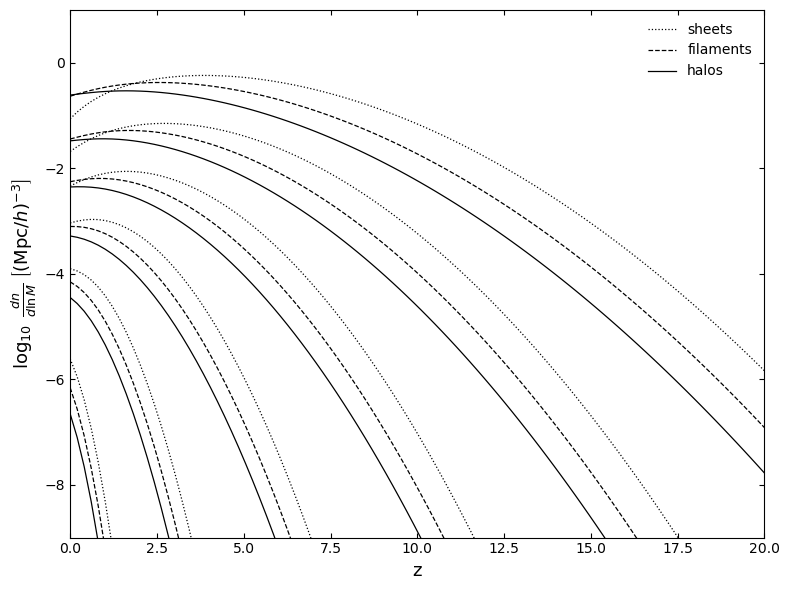

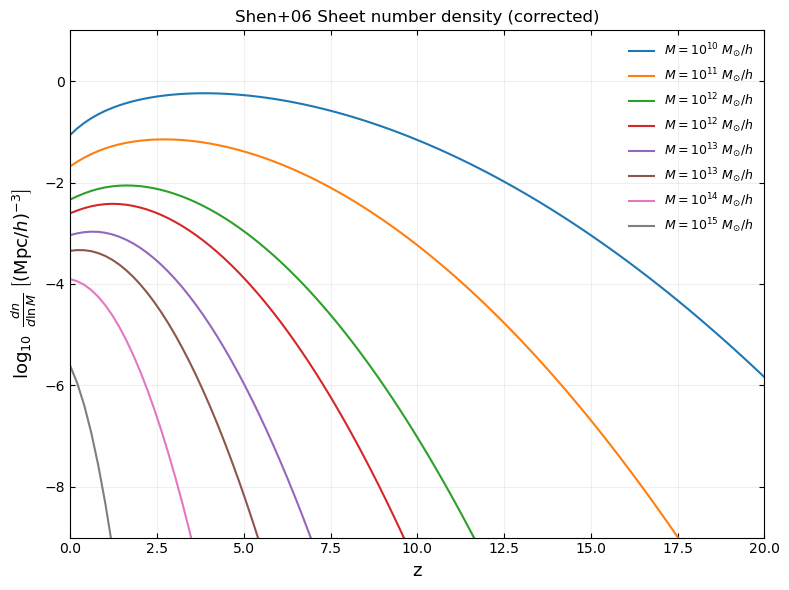

In [81]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import integrate
import math
from functools import lru_cache
%matplotlib inline

# ============================================================
# Shen+06 Figure 3 (bottom-right) reproduction — SHEETS only
# 
# Cosmology from paper Section 2.5:
#   "spatially flat model with Λ0 = 1−Ω0, where (Ω0, h, σ8) = (0.3, 0.7, 0.9)"
#
# Key fixes vs original code:
#   1. Transfer function: Use Efstathiou+88 / BBKS with Γ = Ω_m h = 0.21
#      (the paper's era standard; original code used a different approximation
#       that underestimated T(k) at high k by ~40-50%)
#   2. Spectral index: n_s = 1.0 (scale-invariant Harrison-Zel'dovich, standard 
#      for pre-WMAP3 analyses; original used n_s=0.965)
#   3. Note: Ω_b is not specified in the paper. For a pure CDM transfer function
#      with Γ = Ω_m h, baryons enter only through the shape parameter.
# ============================================================

# --- Cosmological parameters ---
Omega_m = 0.3
Omega_L = 0.7
h_param = 0.7
sigma8 = 0.9
n_s = 1.0          # Harrison-Zel'dovich (paper's era default)
Gamma = Omega_m * h_param  # shape parameter = 0.21


def rho_m0_comoving():
    """Present-day mean matter density in (Msun/h) / (Mpc/h)^3."""
    return 2.775e11 * Omega_m


def mass_to_tophat_radius(M_msun_over_h):
    """Mass M (Msun/h) → comoving tophat radius R (Mpc/h)."""
    rho0 = rho_m0_comoving()
    return (3.0 * M_msun_over_h / (4.0 * np.pi * rho0)) ** (1.0 / 3.0)


# ============================================================
# Background cosmology
# ============================================================

def E_of_a(a):
    """E(a) = H(a)/H0 for flat ΛCDM."""
    return np.sqrt(Omega_m / a**3 + Omega_L)


def growth_factor_Dz(z):
    """Linear growth factor D(z), normalized so D(0) = 1."""
    a = 1.0 / (1.0 + z)
    def integrand(ap):
        return 1.0 / (ap**3 * E_of_a(ap)**3)
    I_a, _ = integrate.quad(integrand, 1e-6, a, limit=300)
    I_1, _ = integrate.quad(integrand, 1e-6, 1.0, limit=300)
    return (E_of_a(a) * I_a) / (E_of_a(1.0) * I_1)


def delta_sc_z(z, delta_c0=1.686):
    """Spherical collapse threshold: δ_sc(z) = δ_c0 / D(z)."""
    return delta_c0 / growth_factor_Dz(z)


# ============================================================
# Power spectrum: BBKS / Efstathiou+88 transfer function
# ============================================================

def T_BBKS(k_hmpc):
    """
    BBKS transfer function (Efstathiou, Bond, White 1992 form)
    with shape parameter Γ = Ω_m h.
    Input: k in h/Mpc. Output: dimensionless T(k).
    """
    q = k_hmpc / Gamma
    return (1.0 + (6.4*q + (3.0*q)**1.5 + (1.7*q)**2)**1.13)**(-1.0/1.13)


def W_tophat(kR):
    """Fourier-space spherical tophat window."""
    return 3.0 * (np.sin(kR) - kR * np.cos(kR)) / (kR**3 + 1e-30)


def _sigma2_R(R_mpc_h, A, kmin=1e-5, kmax=1e3):
    """σ²(R) with amplitude A and BBKS transfer function."""
    def integrand(lnk):
        k = np.exp(lnk)
        P = A * (k**n_s) * T_BBKS(k)**2
        return (k**3 * P / (2.0 * np.pi**2)) * W_tophat(k * R_mpc_h)**2
    val, _ = integrate.quad(integrand, np.log(kmin), np.log(kmax), limit=500)
    return val


# Compute amplitude from σ8
_A_amp = sigma8**2 / _sigma2_R(8.0, 1.0)


@lru_cache(maxsize=8192)
def sigma_of_M(M):
    """σ(M) using BBKS transfer function, normalized to σ8."""
    R = mass_to_tophat_radius(M)
    return np.sqrt(_sigma2_R(R, _A_amp))


# ============================================================
# Shen+06 excursion-set formulas
# ============================================================

def series_bracket(alpha, n_terms=5):
    """
    Series bracket from Eq. (4) of Shen+06:
      S(α) = 1 - α + α(α-1)/2! + α(α-1)(α-2)/3! + ...
    """
    S = 1.0
    if n_terms >= 1:
        S -= alpha
    for nn in range(2, n_terms + 1):
        prod = 1.0
        for j in range(nn):
            prod *= (alpha - j)
        S += prod / math.factorial(nn)
    return S


def nu_f_nu(nu, alpha, beta, n_terms=5):
    """
    Shen+06 Eq. (4): approximate first-crossing distribution
    for barrier δ_ec = δ_sc [1 + β ν^{-α}].
    """
    barrier = 1.0 + beta * nu**(-alpha)
    core = np.sqrt(nu / (2.0 * np.pi)) * np.exp(-0.5 * nu * barrier**2)
    S = series_bracket(alpha, n_terms)
    correction = 1.0 + (beta * nu**(-alpha)) * S
    return core * correction


def dlnsig2_dlnM(M, eps=1e-3):
    """d ln σ²/d ln M (negative quantity)."""
    lnM = np.log(M)
    M1 = np.exp(lnM * (1.0 - eps))
    M2 = np.exp(lnM * (1.0 + eps))
    s1, s2 = sigma_of_M(M1), sigma_of_M(M2)
    return (np.log(s2**2) - np.log(s1**2)) / (np.log(M2) - np.log(M1))


def dn_dlnM(M, z, alpha, beta, n_terms=5):
    """
    Comoving number density dn/d ln M  [(Mpc/h)^{-3}].
    
    From Eq. (1):
      νf(ν) = (M² n(M) / ρ_m0) |d ln M / d ln σ²|
    Rearranging:
      dn/d ln M = M n(M) = (ρ_m0 / M) νf(ν) |d ln σ²/d ln M|
    """
    sig = sigma_of_M(M)
    dsc = delta_sc_z(z)
    nu = (dsc / sig)**2
    nuf = nu_f_nu(nu, alpha, beta, n_terms)
    deriv = dlnsig2_dlnM(M)
    return (rho_m0_comoving() / M) * nuf * np.abs(deriv)


# ============================================================
# Barrier parameters from Eq. (2)
# ============================================================
# Sheets:    δ_ec1 = δ_sc [1 - 0.56 (σ²/δ_sc²)^{0.55}]  → α=0.55, β=-0.56
# Filaments: δ_ec2 = δ_sc [1 - 0.012(σ²/δ_sc²)^{0.28}]  → α=0.28, β=-0.012
# Halos:     δ_ec3 = δ_sc [1 + 0.45 (σ²/δ_sc²)^{0.61}]  → α=0.61, β=0.45

SHEET_PARAMS = (0.55, -0.56)
FILAMENT_PARAMS = (0.28, -0.012)
HALO_PARAMS = (0.61, 0.45)


# ============================================================
# Plot: Shen+06 Figure 3, bottom-right panel
# ============================================================

def plot_figure3_bottomright(
    masses_msun_h=None,
    zmin=0.0, zmax=20.0, nz=100,
    save_path='/home/claude/shen06_fig3_bottomright.png'
):
    if masses_msun_h is None:
        masses_msun_h = [1e10, 1e11, 1e12, 1e13, 1e14, 1e15]

    zs = np.linspace(zmin, zmax, nz)

    fig, ax = plt.subplots(figsize=(8, 6))

    line_styles = {
        'sheets': ':',
        'filaments': '--',
        'halos': '-',
    }
    
    for morph_name, (alpha, beta) in [('sheets', SHEET_PARAMS),
                                       ('filaments', FILAMENT_PARAMS),
                                       ('halos', HALO_PARAMS)]:
        for i, M in enumerate(masses_msun_h):
            vals = []
            for z in zs:
                dn = dn_dlnM(M, z, alpha, beta)
                vals.append(np.log10(dn) if dn > 0 else np.nan)
            
            label = None
            if M == masses_msun_h[0]:
                label = morph_name
            
            ax.plot(zs, vals, linestyle=line_styles[morph_name],
                    color='black', linewidth=0.9, label=label)

    ax.set_xlabel("z", fontsize=13)
    ax.set_ylabel(
        r"$\log_{10}\;\frac{dn}{d\ln M}\;\left[(\mathrm{Mpc}/h)^{-3}\right]$",
        fontsize=13
    )
    ax.set_ylim(-9, 1)
    ax.set_xlim(0, 20)
    ax.legend(frameon=False, fontsize=10)
    ax.tick_params(which='both', direction='in', top=True, right=True)
    plt.tight_layout()
    #plt.savefig(save_path, dpi=150)
    #print(f"Saved {save_path}")
    plt.show()


def plot_sheets_only_color(
    masses_msun_h=None,
    zmin=0.0, zmax=20.0, nz=100,
    save_path='/home/claude/shen06_sheets_color.png'
):
    """Colored version showing only sheets, for easy comparison."""
    if masses_msun_h is None:
        masses_msun_h = [1e10, 1e11, 1e12, 2.5e12, 1e13, 2.5e13, 1e14, 1e15]

    zs = np.linspace(zmin, zmax, nz)
    alpha, beta = SHEET_PARAMS

    fig, ax = plt.subplots(figsize=(8, 6))

    for i, M in enumerate(masses_msun_h):
        vals = []
        for z in zs:
            dn = dn_dlnM(M, z, alpha, beta)
            vals.append(np.log10(dn) if dn > 0 else np.nan)
        ax.plot(zs, vals, label=rf"$M = 10^{{{int(np.log10(M))}}}\ M_{{\odot}}/h$")

    ax.set_xlabel("z", fontsize=13)
    ax.set_ylabel(
        r"$\log_{10}\;\frac{dn}{d\ln M}\;\left[(\mathrm{Mpc}/h)^{-3}\right]$",
        fontsize=13
    )
    ax.set_title("Shen+06 Sheet number density (corrected)")
    ax.legend(frameon=False, fontsize=9)
    ax.set_ylim(-9, 1)
    ax.set_xlim(0, 20)
    ax.grid(True, alpha=0.2)
    ax.tick_params(which='both', direction='in', top=True, right=True)
    plt.tight_layout()
    #plt.savefig(save_path, dpi=150)
    #print(f"Saved {save_path}")
    plt.show()

# Run both plots
plot_figure3_bottomright()
plot_sheets_only_color()

In [73]:
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# from scipy import integrate
# import math
# from functools import lru_cache
# %matplotlib inline
# # ============================================================
# # Shen+06 Figure 3 (bottom-right) reproduction — SHEETS only
# # 
# # Cosmology from paper Section 2.5:
# #   "spatially flat model with Λ0 = 1−Ω0, where (Ω0, h, σ8) = (0.3, 0.7, 0.9)"
# #
# # Key fixes vs original code:
# #   1. Transfer function: Use Efstathiou+88 / BBKS with Γ = Ω_m h = 0.21
# #      (the paper's era standard; original code used a different approximation
# #       that underestimated T(k) at high k by ~40-50%)
# #   2. Spectral index: n_s = 1.0 (scale-invariant Harrison-Zel'dovich, standard 
# #      for pre-WMAP3 analyses; original used n_s=0.965)
# #   3. Note: Ω_b is not specified in the paper. For a pure CDM transfer function
# #      with Γ = Ω_m h, baryons enter only through the shape parameter.
# # ============================================================

# # --- Cosmological parameters ---
# Omega_m = 0.3
# Omega_L = 0.7
# h_param = 0.7
# sigma8 = 0.9
# n_s = 1.0          # Harrison-Zel'dovich (paper's era default)
# Gamma = Omega_m * h_param  # shape parameter = 0.21

# import camb

# def get_sigma_interpolator():
#     pars = camb.CAMBparams()
#     pars.set_cosmology(H0=70, ombh2=0.048*0.7**2, omch2=(0.3-0.048)*0.7**2)
#     pars.InitPower.set_params(ns=1.0, As=2e-9)  # As gets rescaled by sigma8
#     pars.set_matter_power(redshifts=[0], kmax=100.0)
    
#     results = camb.get_results(pars)
#     # Rescale to match sigma8=0.9
#     sigma8_camb = results.get_sigma8_0()
    
#     # Get σ(R) as interpolator
#     return results.get_sigmaR_interpolator()

# sigmaR_interp = get_sigma_interpolator()






# def rho_m0_comoving():
#     """Present-day mean matter density in (Msun/h) / (Mpc/h)^3."""
#     return 2.775e11 * Omega_m


# def mass_to_tophat_radius(M_msun_over_h):
#     """Mass M (Msun/h) → comoving tophat radius R (Mpc/h)."""
#     rho0 = rho_m0_comoving()
#     return (3.0 * M_msun_over_h / (4.0 * np.pi * rho0)) ** (1.0 / 3.0)


# # ============================================================
# # Background cosmology
# # ============================================================

# def E_of_a(a):
#     """E(a) = H(a)/H0 for flat ΛCDM."""
#     return np.sqrt(Omega_m / a**3 + Omega_L)


# def growth_factor_Dz(z):
#     """Linear growth factor D(z), normalized so D(0) = 1."""
#     a = 1.0 / (1.0 + z)
#     def integrand(ap):
#         return 1.0 / (ap**3 * E_of_a(ap)**3)
#     I_a, _ = integrate.quad(integrand, 1e-6, a, limit=300)
#     I_1, _ = integrate.quad(integrand, 1e-6, 1.0, limit=300)
#     return (E_of_a(a) * I_a) / (E_of_a(1.0) * I_1)


# def delta_sc_z(z, delta_c0=1.686):
#     """Spherical collapse threshold: δ_sc(z) = δ_c0 / D(z)."""
#     return delta_c0 / growth_factor_Dz(z)


# # ============================================================
# # Power spectrum: BBKS / Efstathiou+88 transfer function
# # ============================================================

# # def T_BBKS(k_hmpc):
# #     """
# #     BBKS transfer function (Efstathiou, Bond, White 1992 form)
# #     with shape parameter Γ = Ω_m h.
# #     Input: k in h/Mpc. Output: dimensionless T(k).
# #     """
# #     q = k_hmpc / Gamma
# #     return (1.0 + (6.4*q + (3.0*q)**1.5 + (1.7*q)**2)**1.13)**(-1.0/1.13)


# # def W_tophat(kR):
# #     """Fourier-space spherical tophat window."""
# #     return 3.0 * (np.sin(kR) - kR * np.cos(kR)) / (kR**3 + 1e-30)


# # def _sigma2_R(R_mpc_h, A, kmin=1e-5, kmax=1e3):
# #     """σ²(R) with amplitude A and BBKS transfer function."""
# #     def integrand(lnk):
# #         k = np.exp(lnk)
# #         P = A * (k**n_s) * T_BBKS(k)**2
# #         return (k**3 * P / (2.0 * np.pi**2)) * W_tophat(k * R_mpc_h)**2
# #     val, _ = integrate.quad(integrand, np.log(kmin), np.log(kmax), limit=500)
# #     return val


# # # Compute amplitude from σ8
# # _A_amp = sigma8**2 / _sigma2_R(8.0, 1.0)


# # @lru_cache(maxsize=8192)
# # def sigma_of_M(M):
# #     """σ(M) using BBKS transfer function, normalized to σ8."""
# #     R = mass_to_tophat_radius(M)
# #     return np.sqrt(_sigma2_R(R, _A_amp))

# def sigma_of_M(M):
#     R = mass_to_tophat_radius(M)
#     return sigmaR_interp(R)


# # ============================================================
# # Shen+06 excursion-set formulas
# # ============================================================

# def series_bracket(alpha, n_terms=5):
#     """
#     Series bracket from Eq. (4) of Shen+06:
#       S(α) = 1 - α + α(α-1)/2! + α(α-1)(α-2)/3! + ...
#     """
#     S = 1.0
#     if n_terms >= 1:
#         S -= alpha
#     for nn in range(2, n_terms + 1):
#         prod = 1.0
#         for j in range(nn):
#             prod *= (alpha - j)
#         S += prod / math.factorial(nn)
#     return S


# def nu_f_nu(nu, alpha, beta, n_terms=5):
#     """
#     Shen+06 Eq. (4): approximate first-crossing distribution
#     for barrier δ_ec = δ_sc [1 + β ν^{-α}].
#     """
#     barrier = 1.0 + beta * nu**(-alpha)
#     core = np.sqrt(nu / (2.0 * np.pi)) * np.exp(-0.5 * nu * barrier**2)
#     S = series_bracket(alpha, n_terms)
#     correction = 1.0 + (beta * nu**(-alpha)) * S
#     return core * correction


# def dlnsig2_dlnM(M, eps=1e-3):
#     """d ln σ²/d ln M (negative quantity)."""
#     lnM = np.log(M)
#     M1 = np.exp(lnM * (1.0 - eps))
#     M2 = np.exp(lnM * (1.0 + eps))
#     s1, s2 = sigma_of_M(M1), sigma_of_M(M2)
#     return (np.log(s2**2) - np.log(s1**2)) / (np.log(M2) - np.log(M1))


# def dn_dlnM(M, z, alpha, beta, n_terms=5):
#     """
#     Comoving number density dn/d ln M  [(Mpc/h)^{-3}].
    
#     From Eq. (1):
#       νf(ν) = (M² n(M) / ρ_m0) |d ln M / d ln σ²|
#     Rearranging:
#       dn/d ln M = M n(M) = (ρ_m0 / M) νf(ν) |d ln σ²/d ln M|
#     """
#     sig = sigma_of_M(M)
#     dsc = delta_sc_z(z)
#     nu = (dsc / sig)**2
#     nuf = nu_f_nu(nu, alpha, beta, n_terms)
#     deriv = dlnsig2_dlnM(M)
#     return (rho_m0_comoving() / M) * nuf * np.abs(deriv)


# # ============================================================
# # Barrier parameters from Eq. (2)
# # ============================================================
# # Sheets:    δ_ec1 = δ_sc [1 - 0.56 (σ²/δ_sc²)^{0.55}]  → α=0.55, β=-0.56
# # Filaments: δ_ec2 = δ_sc [1 - 0.012(σ²/δ_sc²)^{0.28}]  → α=0.28, β=-0.012
# # Halos:     δ_ec3 = δ_sc [1 + 0.45 (σ²/δ_sc²)^{0.61}]  → α=0.61, β=0.45

# SHEET_PARAMS = (0.55, -0.56)
# FILAMENT_PARAMS = (0.28, -0.012)
# HALO_PARAMS = (0.61, 0.45)


# # ============================================================
# # Plot: Shen+06 Figure 3, bottom-right panel
# # ============================================================

# def plot_figure3_bottomright(
#     masses_msun_h=None,
#     zmin=0.0, zmax=20.0, nz=100,
#     save_path='/home/claude/shen06_fig3_bottomright.png'
# ):
#     if masses_msun_h is None:
#         masses_msun_h = [1e10, 1e11, 1e12, 1e13, 1e14, 1e15]

#     zs = np.linspace(zmin, zmax, nz)

#     fig, ax = plt.subplots(figsize=(8, 6))

#     line_styles = {
#         'sheets': ':',
#         'filaments': '--',
#         'halos': '-',
#     }
    
#     for morph_name, (alpha, beta) in [('sheets', SHEET_PARAMS),
#                                        ('filaments', FILAMENT_PARAMS),
#                                        ('halos', HALO_PARAMS)]:
#         for i, M in enumerate(masses_msun_h):
#             vals = []
#             for z in zs:
#                 dn = dn_dlnM(M, z, alpha, beta)
#                 vals.append(np.log10(dn) if dn > 0 else np.nan)
            
#             label = None
#             if M == masses_msun_h[0]:
#                 label = morph_name
            
#             ax.plot(zs, vals, linestyle=line_styles[morph_name],
#                     color='black', linewidth=0.9, label=label)

#     ax.set_xlabel("z", fontsize=13)
#     ax.set_ylabel(
#         r"$\log_{10}\;\frac{dn}{d\ln M}\;\left[(\mathrm{Mpc}/h)^{-3}\right]$",
#         fontsize=13
#     )
#     ax.set_ylim(-9, 1)
#     ax.set_xlim(0, 20)
#     ax.legend(frameon=False, fontsize=10)
#     ax.tick_params(which='both', direction='in', top=True, right=True)
#     plt.tight_layout()
#     #plt.savefig(save_path, dpi=150)
#     #print(f"Saved {save_path}")
#     plt.show()


# def plot_sheets_only_color(
#     masses_msun_h=None,
#     zmin=0.0, zmax=20.0, nz=100,
#     save_path='/home/claude/shen06_sheets_color.png'
# ):
#     """Colored version showing only sheets, for easy comparison."""
#     if masses_msun_h is None:
#         masses_msun_h = [1e10, 1e11, 1e12, 2.5e12, 1e13, 2.5e13, 1e14, 1e15]

#     zs = np.linspace(zmin, zmax, nz)
#     alpha, beta = SHEET_PARAMS

#     fig, ax = plt.subplots(figsize=(8, 6))

#     for i, M in enumerate(masses_msun_h):
#         vals = []
#         for z in zs:
#             dn = dn_dlnM(M, z, alpha, beta)
#             vals.append(np.log10(dn) if dn > 0 else np.nan)
#         ax.plot(zs, vals, label=rf"$M = 10^{{{int(np.log10(M))}}}\ M_{{\odot}}/h$")

#     ax.set_xlabel("z", fontsize=13)
#     ax.set_ylabel(
#         r"$\log_{10}\;\frac{dn}{d\ln M}\;\left[(\mathrm{Mpc}/h)^{-3}\right]$",
#         fontsize=13
#     )
#     ax.set_title("Shen+06 Sheet number density (corrected)")
#     ax.legend(frameon=False, fontsize=9)
#     ax.set_ylim(-9, 1)
#     ax.set_xlim(0, 20)
#     ax.grid(True, alpha=0.2)
#     ax.tick_params(which='both', direction='in', top=True, right=True)
#     plt.tight_layout()
#     #plt.savefig(save_path, dpi=150)
#     #print(f"Saved {save_path}")
#     plt.show()

# # Run both plots
# plot_figure3_bottomright()
# plot_sheets_only_color()

ModuleNotFoundError: No module named 'camb'

In [84]:
import numpy as np

# ============================================================
# Helpers for geometry + cosmology
# ============================================================

def A_face_square_pancake(M, rho_m0):
    """
    Square-pancake comoving face area:
      A_face = (M / rho_m0)^(2/3)
    Units: (Mpc/h)^2 if M is Msun/h and rho_m0 is (Msun/h)/(Mpc/h)^3.
    """
    return (M / rho_m0) ** (2.0 / 3.0)


def Aproj_avg(M, rho_m0, cos_abs_mean=0.5):
    """
    Orientation-averaged projected area:
      <A_perp> = <|cosθ|> * A_face
    For isotropic orientations: <|cosθ|> = 1/2.
    """
    return cos_abs_mean * A_face_square_pancake(M, rho_m0)


def E_z(z, Omega_m, Omega_L):
    """E(z)=H(z)/H0 for flat LCDM (radiation neglected)."""
    return np.sqrt(Omega_m * (1.0 + z)**3 + Omega_L)


def dchi_dz_comoving(z, Omega_m, Omega_L):
    """
    dχ/dz = c/H(z) in (Mpc/h) per unit z if H0=100 km/s/(Mpc/h).
    """
    c_kms = 299792.458
    Hz = 100.0 * E_z(z, Omega_m, Omega_L)  # km/s/(Mpc/h)
    return c_kms / Hz


# ============================================================
# Inner integral over ln M: I(z) = ∫ dlnM (dn/dlnM)(M,z) <A_perp(M)>
# ============================================================

def mass_integrand_dlnM(M, z, dn_dlnM_func, rho_m0, cos_abs_mean):
    """
    Integrand inside the lnM integral:
      (dn/dlnM)(M,z) * <A_perp(M)>
    Units: (Mpc/h)^-3 * (Mpc/h)^2 = (Mpc/h)^-1
    """
    return dn_dlnM_func(M, z) * Aproj_avg(M, rho_m0, cos_abs_mean=cos_abs_mean)


def integrate_over_lnM_at_z(
    z,
    Mmin,
    dn_dlnM_func,
    rho_m0,
    cos_abs_mean=0.5,
    Mmax=1e16,
    dlog10M=0.02,
):
    """
    Secondary function (2nd integral): integrate over ln M at fixed z.

    Computes:
      I(z) = ∫_{ln Mmin}^{ln Mmax} dlnM (dn/dlnM)(M,z) <A_perp(M)>

    Uses uniform spacing in log10M; converts to dlnM = ln(10)*dlog10M.
    """
    log10M = np.arange(np.log10(Mmin), np.log10(Mmax) + dlog10M, dlog10M)
    M = 10**log10M
    dlnM = np.log(10.0) * dlog10M

    integrand = np.array([mass_integrand_dlnM(Mi, z, dn_dlnM_func, rho_m0, cos_abs_mean) for Mi in M])
    return np.sum(integrand * dlnM)  # units: (Mpc/h)^-1


# ============================================================
# Outer integral over z: N = ∫ dz (dχ/dz) I(z)
# ============================================================

def z_integrand(
    z,
    Mmin,
    dn_dlnM_func,
    rho_m0,
    Omega_m,
    Omega_L,
    cos_abs_mean,
    Mmax,
    dlog10M,
):
    """
    Integrand inside the z integral:
      (dχ/dz)(z) * I(z)
    Returns dimensionless per unit z.
    """
    I_z = integrate_over_lnM_at_z(
        z=z,
        Mmin=Mmin,
        dn_dlnM_func=dn_dlnM_func,
        rho_m0=rho_m0,
        cos_abs_mean=cos_abs_mean,
        Mmax=Mmax,
        dlog10M=dlog10M,
    )
    return dchi_dz_comoving(z, Omega_m, Omega_L) * I_z


def expected_intersections(
    z_hi,
    z_lo,
    Mmin,
    dn_dlnM_func,
    rho_m0,
    Omega_m,
    Omega_L,
    cos_abs_mean=0.5,
    Mmax=1e16,
    dlog10M=0.02,
    dz=0.01,
):
    """
    Primary function (1st integral): expected number of intersections.

    N = ∫_{z_lo}^{z_hi} dz (dχ/dz)(z) * ∫ dlnM (dn/dlnM)(M,z) <A_perp(M)>
    """
    z1, z2 = (z_hi, z_lo) if z_hi >= z_lo else (z_lo, z_hi)
    zs = np.arange(z2, z1 + dz, dz)

    vals = np.array([
        z_integrand(z, Mmin, dn_dlnM_func, rho_m0, Omega_m, Omega_L, cos_abs_mean, Mmax, dlog10M)
        for z in zs
    ])
    return np.trapezoid(vals, zs)


def intersection_probability_poisson(N):
    """P(>=1) = 1 - exp(-N)."""
    return 1.0 - np.exp(-N)


# ============================================================
# Example: plug in *your* dn_dlnM(M,z,alpha,beta,...) by wrapping it
# ============================================================


In [89]:

# You have: dn_dlnM(M, z, alpha, beta, n_terms=5)
# We'll wrap alpha/beta so the integrator only sees (M,z).

def make_dn_dlnM_wrapper(alpha, beta, n_terms=5):
    def _f(M, z):
        return dn_dlnM(M, z, alpha=alpha, beta=beta, n_terms=n_terms)
    return _f

#Example usage:
alpha_sheet, beta_sheet = 0.55, -0.56
dn_func = make_dn_dlnM_wrapper(alpha_sheet, beta_sheet, n_terms=5)
rho0 = rho_m0_comoving()   # your function (must return (Msun/h)/(Mpc/h)^3)

N = expected_intersections(
    z_hi=5, z_lo=3,
    Mmin=1e13,
    dn_dlnM_func=dn_func,
    rho_m0=rho0,
    Omega_m=0.3, Omega_L=0.7,
    cos_abs_mean=0.5,
    Mmax=1e16,
    dlog10M=0.02,
    dz=0.01
)
P = intersection_probability_poisson(N)
print("N =", N, " P(>=1) =", P)

N = 0.2024284607220767  P(>=1) = 0.1832550901507376
